In [1]:
import numpy
import pandas
import seaborn
import logging
import time
import collections
import os
from os import environ
from matplotlib import pyplot

import sklearn
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.linear_model

from six import string_types

%matplotlib inline
logging.basicConfig(level="DEBUG")

pandas.set_option('display.max_columns', 60)

from mhc2flurry.downloads import get_path
import mhc2flurry

from copy import deepcopy
import shutil
from Bio import SeqIO
import bz2

import tensorflow as tf
#config = tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)
#session = tf.Session(config=config)
#K.set_session(session)

def ppv(y_true, predictions):
    df = pandas.DataFrame({"prediction": predictions, "y_true": y_true})
    return df.sort_values("prediction", ascending=False)[:int(y_true.sum())].y_true.mean()

import Bio.SeqIO
import traceback
from gzip import GzipFile
import Bio
import Bio.SeqUtils
from glob import glob
import json
from scipy.stats import pearsonr

import tqdm

from notebook.services.config import ConfigManager
c = ConfigManager()
c.update('notebook', {"CodeCell": {"cm_config": {"autoCloseBrackets": False}}})

import mhcgnomes

import mhc2flurry.allele_encoding_pair
import mhc2flurry.allele_encoding

from mhcflurry.regression_target import from_ic50, to_ic50

DEBUG:root:Configured MHC2FLURRY_DOWNLOADS_DIR: /home/odonnt02/.local/share/mhc2flurry/1/0.0.1
DEBUG:tensorflow:Falling back to TensorFlow client; we recommended you install the Cloud TPU client directly with pip install cloud-tpu-client.
INFO:numexpr.utils:Note: NumExpr detected 24 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
DEBUG:root:Configured MHCFLURRY_DOWNLOADS_DIR: /home/odonnt02/.local/share/mhcflurry/4/2.0.0
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [2]:
#!pip install -e /Users/tim/sinai/git/mhcflurry

In [3]:
!ls "$(mhc2flurry-downloads path data_curated)"

curated_training_data.affinity.csv.bz2		expression
curated_training_data.csv.bz2			GENERATE.sh
curated_training_data.mass_spec.csv.bz2		LOG.txt.bz2
curated_training_data.no_additional_ms.csv.bz2	ms.by_pmid.csv.bz2
curate_ms_by_pmid.py				rna_expression.csv.bz2
curate.py					rna_expression.metadata.csv.bz2
DOWNLOAD_INFO.csv


In [56]:
!cat "$(mhc2flurry-downloads path data_curated)/DOWNLOAD_INFO.csv"

url
https://github.com/openvax/mhc2flurry/releases/download/pre-0.0.1/data_curated.20201103.tar.bz2


In [58]:
!mhc2flurry-downloads info

Environment variables
  MHC2FLURRY_DATA_DIR                 [unset or empty]
  MHC2FLURRY_DOWNLOADS_CURRENT_RELEASE [unset or empty]
  MHC2FLURRY_DOWNLOADS_DIR            [unset or empty]
  MHC2FLURRY_DEFAULT_MODELS_DIR       [unset or empty]
  MHC2FLURRY_DOWNLOADS_GITHUB_AUTH_TOKEN [unset or empty]

Configuration
  current release                     = 0.0.1                
  downloads dir                       = /home/odonnt02/.local/share/mhc2flurry/1/0.0.1 [exists]

DOWNLOAD NAME                             DOWNLOADED?   UP TO DATE?   URL                  
allele_sequences                          YES           YES           https://github.com/openvax/mhc2flurry/releases/download/pre-0.0.1/allele_sequences.20210222.tar.bz2 
data_curated                              YES           YES           https://github.com/openvax/mhc2flurry/releases/download/pre-0.0.1/data_curated.20201103.tar.bz2 
data_published                            NO                          https://github.com/openva

In [4]:
train_df = pandas.read_csv(get_path("data_curated", "curated_training_data.csv.bz2"))
train_df

,allele,peptide,measurement_value,measurement_inequality,measurement_type,measurement_kind,measurement_source,original_allele
0,BoLA-DRB3*001:01,AYAAQGYKVLVLNPSVAA,1541.0,=,quantitative,affinity,Walker - purified MHC/competitive/radioactivity,BoLA-DRB3*001:01
1,BoLA-DRB3*001:01,CGKYLFNWAVRTKLKLTPIA,8776.0,=,quantitative,affinity,Walker - purified MHC/competitive/radioactivity,BoLA-DRB3*001:01
2,BoLA-DRB3*001:01,ENLPYLVAYQATVCARAQAP,36805.0,=,quantitative,affinity,Walker - purified MHC/competitive/radioactivity,BoLA-DRB3*001:01
3,BoLA-DRB3*001:01,GIQYLAGLSTLPGNPAIASL,100000.0,>,quantitative,affinity,Walker - purified MHC/competitive/radioactivity,BoLA-DRB3*001:01
4,BoLA-DRB3*001:01,KGGRKPARLIVFPDLGVRVC,3336.0,=,quantitative,affinity,Walker - purified MHC/competitive/radioactivity,BoLA-DRB3*001:01
...,...,...,...,...,...,...,...,...
311334,Mamu-DRB1*04:06,YKTIAFDEEARR,5000.0,>,quantitative,affinity,Sette - purified MHC/competitive/radioactivity,Mamu-DRB1*04:06
311335,Mamu-DRB1*04:06,YLCLIQKALFMHCKK,1000.0,>,quantitative,affinity,Sette - purified MHC/competitive/radioactivity,Mamu-DRB1*04:06
311336,Mamu-DRB1*04:06,YVPHFKVGWAWWTCS,1000.0,>,quantitative,affinity,Sette - purified MHC/competitive/radioactivity,Mamu-DRB1*04:06
311337,Patr-DRB1*03:08,KTIAYDEEARR,100.0,<,qualitative,affinity,Bontrop - cellular MHC/direct/fluorescence,Patr-DRB1*03:08


In [5]:
train_df.measurement_type.value_counts()
train_df.measurement_source.value_counts()
train_df.measurement_kind.value_counts()
train_df.loc[train_df.measurement_kind == "mass_spec"].measurement_source.value_counts()


Falkenburg - cellular MHC/mass spectrometry             81031
Neidert - cellular MHC/mass spectrometry                45387
MS:pmid:31495665                                        43332
Sollid - cellular MHC/mass spectrometry                 18926
Alizadeh - cellular MHC/mass spectrometry                4058
Santambrogio - cellular MHC/mass spectrometry            3172
Fugmann - cellular MHC/mass spectrometry                 2604
Rossjohn - cellular MHC/mass spectrometry                2071
Howard - cellular MHC/mass spectrometry                  2032
Brunham - cellular MHC/mass spectrometry                 1453
Jaraquemada - cellular MHC/mass spectrometry             1238
Roep - cellular MHC/mass spectrometry                    1086
Ytterberg - cellular MHC/mass spectrometry                855
Alvarez - cellular MHC/mass spectrometry                  696
Phillips - cellular MHC/mass spectrometry                 551
Joyce - mass spectrometry                                 391
Maric - 

In [6]:
train_df.loc[train_df.measurement_kind == "mass_spec"].measurement_inequality.value_counts()

<    211639
Name: measurement_inequality, dtype: int64

In [7]:
train_df.loc[train_df.measurement_source.str.contains("Falkenburg")].measurement_inequality.value_counts()

<    81031
Name: measurement_inequality, dtype: int64

In [8]:
train_ms_df = pandas.read_csv(get_path("data_curated", "ms.by_pmid.csv.bz2"))
train_ms_df = train_ms_df.loc[
    train_ms_df.mhc_class == "II"
]
train_ms_df

,pmid,sample_id,peptide,format,mhc_class,hla,expression_dataset,cell_line,intensity,original_pmid,pulldown_antibody,sample_type
0,31495665,MAPTAC_DRB1*12:01_DM-,APVKKLVVKGGKKKKQVLKFTLD,MONOALLELIC,II,HLA-DRA*01:01-DRB1*12:01,cell_line:EXPI293,EXPI293,NaN,31495665,MAPTAC,EXPI293
1,31495665,MAPTAC_DRB1*12:01_DM-,VPGPGPAPMPSDFQVLRAKY,MONOALLELIC,II,HLA-DRA*01:01-DRB1*12:01,cell_line:EXPI293,EXPI293,NaN,31495665,MAPTAC,EXPI293
2,31495665,MAPTAC_DRB1*12:01_DM-,IGNLMVSPPVKVQGKE,MONOALLELIC,II,HLA-DRA*01:01-DRB1*12:01,cell_line:EXPI293,EXPI293,NaN,31495665,MAPTAC,EXPI293
3,31495665,MAPTAC_DRB1*12:01_DM-,ALMGYATHKYLDSEEDEE,MONOALLELIC,II,HLA-DRA*01:01-DRB1*12:01,cell_line:EXPI293,EXPI293,NaN,31495665,MAPTAC,EXPI293
4,31495665,MAPTAC_DRB1*12:01_DM-,GSDQSENVDRGAGSIREA,MONOALLELIC,II,HLA-DRA*01:01-DRB1*12:01,cell_line:EXPI293,EXPI293,NaN,31495665,MAPTAC,EXPI293
...,...,...,...,...,...,...,...,...,...,...,...,...
297642,31611696,3912_BAM-HLA-DR-DEPLETED,YYYIQQDTKGDYQKA,DR-DEPLETED,II,HLA-DRB1*03:01 HLA-DRB1*04:01 HLA-DRB3*01:01 H...,sample_type:MENINGIOMA,NaN,23.62321,31611696,NaN,MENINGIOMA
297643,31611696,4052_BA-HLA-DR,YYYIQQDTKGDYQKA,DR-SPECIFIC,II,HLA-DRB1*03:01 HLA-DRB1*11:04 HLA-DRB3*01:01 H...,sample_type:MENINGIOMA,NaN,30.98475,31611696,HB298,MENINGIOMA
297644,31611696,4052_BA-HLA-DR-DEPLETED,YYYIQQDTKGDYQKA,DR-DEPLETED,II,HLA-DRB1*03:01 HLA-DRB1*11:04 HLA-DRB3*01:01 H...,sample_type:MENINGIOMA,NaN,22.62017,31611696,NaN,MENINGIOMA
297645,31611696,3912_BAM-HLA-DR,YYYIQQDTKGDYQKAL,DR-SPECIFIC,II,HLA-DRB1*03:01 HLA-DRB1*04:01 HLA-DRB3*01:01 H...,sample_type:MENINGIOMA,NaN,28.35611,31611696,HB298,MENINGIOMA


In [9]:
affinity_df = train_df.loc[
    (~train_df.peptide.isin(train_ms_df.peptide)) &
    (train_df.measurement_kind == "affinity")
]
affinity_df

,allele,peptide,measurement_value,measurement_inequality,measurement_type,measurement_kind,measurement_source,original_allele
0,BoLA-DRB3*001:01,AYAAQGYKVLVLNPSVAA,1541.0,=,quantitative,affinity,Walker - purified MHC/competitive/radioactivity,BoLA-DRB3*001:01
1,BoLA-DRB3*001:01,CGKYLFNWAVRTKLKLTPIA,8776.0,=,quantitative,affinity,Walker - purified MHC/competitive/radioactivity,BoLA-DRB3*001:01
2,BoLA-DRB3*001:01,ENLPYLVAYQATVCARAQAP,36805.0,=,quantitative,affinity,Walker - purified MHC/competitive/radioactivity,BoLA-DRB3*001:01
3,BoLA-DRB3*001:01,GIQYLAGLSTLPGNPAIASL,100000.0,>,quantitative,affinity,Walker - purified MHC/competitive/radioactivity,BoLA-DRB3*001:01
4,BoLA-DRB3*001:01,KGGRKPARLIVFPDLGVRVC,3336.0,=,quantitative,affinity,Walker - purified MHC/competitive/radioactivity,BoLA-DRB3*001:01
...,...,...,...,...,...,...,...,...
311334,Mamu-DRB1*04:06,YKTIAFDEEARR,5000.0,>,quantitative,affinity,Sette - purified MHC/competitive/radioactivity,Mamu-DRB1*04:06
311335,Mamu-DRB1*04:06,YLCLIQKALFMHCKK,1000.0,>,quantitative,affinity,Sette - purified MHC/competitive/radioactivity,Mamu-DRB1*04:06
311336,Mamu-DRB1*04:06,YVPHFKVGWAWWTCS,1000.0,>,quantitative,affinity,Sette - purified MHC/competitive/radioactivity,Mamu-DRB1*04:06
311337,Patr-DRB1*03:08,KTIAYDEEARR,100.0,<,qualitative,affinity,Bontrop - cellular MHC/direct/fluorescence,Patr-DRB1*03:08


In [25]:
allele_sequences_df = pandas.read_csv(get_path("allele_sequences", "allele_sequences.csv"), index_col=0)
allele_sequences_variant = allele_sequences_df.columns[0]
print("using variant", allele_sequences_variant)
allele_sequences_alpha = allele_sequences_df.loc[allele_sequences_df.kind == "alpha", allele_sequences_variant]
allele_sequences_beta = allele_sequences_df.loc[allele_sequences_df.kind == "beta", allele_sequences_variant]
allele_sequences_alpha, allele_sequences_beta

using variant maf_0.2_and_0.3_within_6.0_angstrom


(sequence_id
 HLA-DPA1*02:38Q    SYMFFQRAFSEGGAIILNTL
 HLA-DPA1*01:03     SYAFFMQAFSEGGAIILNTL
 HLA-DPA1*01:03Q    SYAFFMQAFSEGGAIILNTL
 HLA-DPA1*01:14     SYAFFMQAFSEGGAIILNTL
 HLA-DPA1*01:18     SYAFFMQAFSEGGAIILNTL
                            ...         
 HLA-DPA1*01:46     SYAFFMQAFSEGGAIILNTL
 HLA-DPA1*01:05     SYAFFMQAFSEGGAIILNTL
 HLA-DPA1*01:41     SYAFFMQAFSEGGAIILNTL
 HLA-DPA1*02:03     SYAFFMRAFSEGGAIILNTL
 HLA-DPA1*02:16     SYAFFQRAFSEGGAIILNTL
 Name: maf_0.2_and_0.3_within_6.0_angstrom, Length: 174, dtype: object,
 sequence_id
 HLA-DQB1*05:03      YFGGTHYVYDVGASRVEVAYGI
 HLA-DQB1*05:08      YFGGTHYVYDVGASRVEVAYGI
 HLA-DQB1*05:10      YFGGTHYVYDVGASRVEVAYGI
 HLA-DQB1*05:108     YFGGTHYVYDVGASRVEVAYGI
 HLA-DQB1*05:134     YFGGTHYVYDVGASRVEVAYGI
                              ...          
 HLA-DQB1*03:422N    YFGLTYYAYAVRTETVQLELTT
 HLA-DRB1*12:06      ESGLEHLLFVIDRATYGAVEFT
 HLA-DRB4*01:124     EACNIYYAYDLRRETYGVVEFT
 HLA-DRB5*01:08N     QDYFHGNVYDFDRATYGVGEFT
 HLA-DQB1*0

In [26]:
mhcgnomes.parse("Patr-DRB1*03:08", infer_class2_pairing=True)

Allele(gene=Gene(species=Species(name='Pan troglodytes', mhc_prefix='Patr'), name='DRB1'), allele_fields=('03', '08'), annotations=(), mutations=())

In [27]:
mhcgnomes.parse("HLA-DRB1*03:08", infer_class2_pairing=True)

Class2Pair(alpha=Allele(gene=Gene(species=Species(name='Homo sapiens', mhc_prefix='HLA'), name='DRA'), allele_fields=('01', '01'), annotations=(), mutations=()), beta=Allele(gene=Gene(species=Species(name='Homo sapiens', mhc_prefix='HLA'), name='DRB1'), allele_fields=('03', '08'), annotations=(), mutations=()), mhc_class='IIa')

In [28]:
train_df.loc[
    ~train_df.peptide.isin(train_ms_df.peptide)
]

,allele,peptide,measurement_value,measurement_inequality,measurement_type,measurement_kind,measurement_source,original_allele,parsed_allele
0,BoLA-DRB3*001:01,AYAAQGYKVLVLNPSVAA,1541.0,=,quantitative,affinity,Walker - purified MHC/competitive/radioactivity,BoLA-DRB3*001:01,Allele(gene=Gene(species=Species(name='Bos sp....
1,BoLA-DRB3*001:01,CGKYLFNWAVRTKLKLTPIA,8776.0,=,quantitative,affinity,Walker - purified MHC/competitive/radioactivity,BoLA-DRB3*001:01,Allele(gene=Gene(species=Species(name='Bos sp....
2,BoLA-DRB3*001:01,ENLPYLVAYQATVCARAQAP,36805.0,=,quantitative,affinity,Walker - purified MHC/competitive/radioactivity,BoLA-DRB3*001:01,Allele(gene=Gene(species=Species(name='Bos sp....
3,BoLA-DRB3*001:01,GIQYLAGLSTLPGNPAIASL,100000.0,>,quantitative,affinity,Walker - purified MHC/competitive/radioactivity,BoLA-DRB3*001:01,Allele(gene=Gene(species=Species(name='Bos sp....
4,BoLA-DRB3*001:01,KGGRKPARLIVFPDLGVRVC,3336.0,=,quantitative,affinity,Walker - purified MHC/competitive/radioactivity,BoLA-DRB3*001:01,Allele(gene=Gene(species=Species(name='Bos sp....
...,...,...,...,...,...,...,...,...,...
311334,Mamu-DRB1*04:06,YKTIAFDEEARR,5000.0,>,quantitative,affinity,Sette - purified MHC/competitive/radioactivity,Mamu-DRB1*04:06,Allele(gene=Gene(species=Species(name='Macaca ...
311335,Mamu-DRB1*04:06,YLCLIQKALFMHCKK,1000.0,>,quantitative,affinity,Sette - purified MHC/competitive/radioactivity,Mamu-DRB1*04:06,Allele(gene=Gene(species=Species(name='Macaca ...
311336,Mamu-DRB1*04:06,YVPHFKVGWAWWTCS,1000.0,>,quantitative,affinity,Sette - purified MHC/competitive/radioactivity,Mamu-DRB1*04:06,Allele(gene=Gene(species=Species(name='Macaca ...
311337,Patr-DRB1*03:08,KTIAYDEEARR,100.0,<,qualitative,affinity,Bontrop - cellular MHC/direct/fluorescence,Patr-DRB1*03:08,Allele(gene=Gene(species=Species(name='Pan tro...


In [29]:
train_df["parsed_allele"] = train_df.allele.map(lambda s: mhcgnomes.parse(s, infer_class2_pairing=True))
train_df

,allele,peptide,measurement_value,measurement_inequality,measurement_type,measurement_kind,measurement_source,original_allele,parsed_allele
0,BoLA-DRB3*001:01,AYAAQGYKVLVLNPSVAA,1541.0,=,quantitative,affinity,Walker - purified MHC/competitive/radioactivity,BoLA-DRB3*001:01,Allele(gene=Gene(species=Species(name='Bos sp....
1,BoLA-DRB3*001:01,CGKYLFNWAVRTKLKLTPIA,8776.0,=,quantitative,affinity,Walker - purified MHC/competitive/radioactivity,BoLA-DRB3*001:01,Allele(gene=Gene(species=Species(name='Bos sp....
2,BoLA-DRB3*001:01,ENLPYLVAYQATVCARAQAP,36805.0,=,quantitative,affinity,Walker - purified MHC/competitive/radioactivity,BoLA-DRB3*001:01,Allele(gene=Gene(species=Species(name='Bos sp....
3,BoLA-DRB3*001:01,GIQYLAGLSTLPGNPAIASL,100000.0,>,quantitative,affinity,Walker - purified MHC/competitive/radioactivity,BoLA-DRB3*001:01,Allele(gene=Gene(species=Species(name='Bos sp....
4,BoLA-DRB3*001:01,KGGRKPARLIVFPDLGVRVC,3336.0,=,quantitative,affinity,Walker - purified MHC/competitive/radioactivity,BoLA-DRB3*001:01,Allele(gene=Gene(species=Species(name='Bos sp....
...,...,...,...,...,...,...,...,...,...
311334,Mamu-DRB1*04:06,YKTIAFDEEARR,5000.0,>,quantitative,affinity,Sette - purified MHC/competitive/radioactivity,Mamu-DRB1*04:06,Allele(gene=Gene(species=Species(name='Macaca ...
311335,Mamu-DRB1*04:06,YLCLIQKALFMHCKK,1000.0,>,quantitative,affinity,Sette - purified MHC/competitive/radioactivity,Mamu-DRB1*04:06,Allele(gene=Gene(species=Species(name='Macaca ...
311336,Mamu-DRB1*04:06,YVPHFKVGWAWWTCS,1000.0,>,quantitative,affinity,Sette - purified MHC/competitive/radioactivity,Mamu-DRB1*04:06,Allele(gene=Gene(species=Species(name='Macaca ...
311337,Patr-DRB1*03:08,KTIAYDEEARR,100.0,<,qualitative,affinity,Bontrop - cellular MHC/direct/fluorescence,Patr-DRB1*03:08,Allele(gene=Gene(species=Species(name='Pan tro...


In [30]:
use_train_df = train_df.loc[train_df.parsed_allele.map(lambda p: isinstance(p, mhcgnomes.Class2Pair))].copy()
use_train_df["alpha_allele"] = use_train_df.parsed_allele.map(lambda p: p.alpha.to_string())
use_train_df["beta_allele"] = use_train_df.parsed_allele.map(lambda p: p.beta.to_string())

use_train_df = use_train_df.loc[
    (use_train_df.alpha_allele.isin(allele_sequences_alpha.index)) &
    (use_train_df.beta_allele.isin(allele_sequences_beta.index))
].copy()

use_train_df = use_train_df.loc[
    (use_train_df.measurement_kind == "affinity")
].copy()
use_train_df["allele"] = use_train_df.allele.map(lambda s: mhcgnomes.parse(s, infer_class2_pairing=True).to_string())
use_train_df

,allele,peptide,measurement_value,measurement_inequality,measurement_type,measurement_kind,measurement_source,original_allele,parsed_allele,alpha_allele,beta_allele
9944,HLA-DPA1*01:03-DPB1*02:01,AAAAGWQTLSAALDA,3770.0,=,quantitative,affinity,Sette - purified MHC/competitive/radioactivity,HLA-DPA1*01:03/DPB1*02:01,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DPA1*01:03,HLA-DPB1*02:01
9946,HLA-DPA1*01:03-DPB1*02:01,AAAGAEAGKATTEEQ,46700.0,>,quantitative,affinity,Sette - purified MHC/competitive/radioactivity,HLA-DPA1*01:03/DPB1*02:01,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DPA1*01:03,HLA-DPB1*02:01
9961,HLA-DPA1*01:03-DPB1*02:01,AAASVPAADKFKTFE,5520.0,=,quantitative,affinity,Sette - purified MHC/competitive/radioactivity,HLA-DPA1*01:03/DPB1*02:01,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DPA1*01:03,HLA-DPB1*02:01
9962,HLA-DPA1*01:03-DPB1*02:01,AAATATATAAVGAAT,46700.0,>,quantitative,affinity,Sette - purified MHC/competitive/radioactivity,HLA-DPA1*01:03/DPB1*02:01,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DPA1*01:03,HLA-DPB1*02:01
9964,HLA-DPA1*01:03-DPB1*02:01,AADHAAPEDKYEAFV,781.0,=,quantitative,affinity,Sette - purified MHC/competitive/radioactivity,HLA-DPA1*01:03/DPB1*02:01,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DPA1*01:03,HLA-DPB1*02:01
...,...,...,...,...,...,...,...,...,...,...,...
309988,HLA-DRA*01:01-DRB5*01:02,VSILQTASSGLTSLTNSLQR,5000.0,<,qualitative,affinity,Robinson - purified MHC/direct/fluorescence,HLA-DRB5*01:02,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB5*01:02
309989,HLA-DRA*01:01-DRB5*01:02,VTAVFGSSTAGTGTAASPSF,5000.0,<,qualitative,affinity,Robinson - purified MHC/direct/fluorescence,HLA-DRB5*01:02,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB5*01:02
309990,HLA-DRA*01:01-DRB5*01:02,VTPRTPPPSQGKGRGLSLSR,20000.0,>,quantitative,affinity,Adorini - purified MHC/competitive/radioactivity,HLA-DRB5*01:02,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB5*01:02
309991,HLA-DRA*01:01-DRB5*01:02,YKSAHKGFKGVDAQGTLSKI,4100.0,=,quantitative,affinity,Adorini - purified MHC/competitive/radioactivity,HLA-DRB5*01:02,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB5*01:02


In [53]:
use_train_df.allele.value_counts()

AttributeError: 'DataFrame' object has no attribute 'hla'

In [32]:
validation_df = train_ms_df.loc[
    (train_ms_df.format == "MONOALLELIC") &
    (~train_ms_df.peptide.isin(use_train_df.peptide))
].copy()
validation_df["parsed_allele"] = validation_df.hla.map(lambda s: mhcgnomes.parse(s, infer_class2_pairing=True))

validation_df = validation_df.loc[validation_df.parsed_allele.map(lambda p: isinstance(p, mhcgnomes.Class2Pair))].copy()
validation_df["alpha_allele"] = validation_df.parsed_allele.map(lambda p: p.alpha.to_string())
validation_df["beta_allele"] = validation_df.parsed_allele.map(lambda p: p.beta.to_string())

validation_df

,pmid,sample_id,peptide,format,mhc_class,hla,expression_dataset,cell_line,intensity,original_pmid,pulldown_antibody,sample_type,parsed_allele,alpha_allele,beta_allele
0,31495665,MAPTAC_DRB1*12:01_DM-,APVKKLVVKGGKKKKQVLKFTLD,MONOALLELIC,II,HLA-DRA*01:01-DRB1*12:01,cell_line:EXPI293,EXPI293,NaN,31495665,MAPTAC,EXPI293,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB1*12:01
1,31495665,MAPTAC_DRB1*12:01_DM-,VPGPGPAPMPSDFQVLRAKY,MONOALLELIC,II,HLA-DRA*01:01-DRB1*12:01,cell_line:EXPI293,EXPI293,NaN,31495665,MAPTAC,EXPI293,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB1*12:01
2,31495665,MAPTAC_DRB1*12:01_DM-,IGNLMVSPPVKVQGKE,MONOALLELIC,II,HLA-DRA*01:01-DRB1*12:01,cell_line:EXPI293,EXPI293,NaN,31495665,MAPTAC,EXPI293,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB1*12:01
3,31495665,MAPTAC_DRB1*12:01_DM-,ALMGYATHKYLDSEEDEE,MONOALLELIC,II,HLA-DRA*01:01-DRB1*12:01,cell_line:EXPI293,EXPI293,NaN,31495665,MAPTAC,EXPI293,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB1*12:01
4,31495665,MAPTAC_DRB1*12:01_DM-,GSDQSENVDRGAGSIREA,MONOALLELIC,II,HLA-DRA*01:01-DRB1*12:01,cell_line:EXPI293,EXPI293,NaN,31495665,MAPTAC,EXPI293,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB1*12:01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45631,31495665,MAPTAC_DRB1*15:01,AQNVGTTHDL,MONOALLELIC,II,HLA-DRA*01:01-DRB1*15:01,cell_line:EXPI293,EXPI293,NaN,31495665,MAPTAC,EXPI293,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB1*15:01
45632,31495665,MAPTAC_DRB1*15:01,YPHRPVLMVISHAAPHGPE,MONOALLELIC,II,HLA-DRA*01:01-DRB1*15:01,cell_line:EXPI293,EXPI293,NaN,31495665,MAPTAC,EXPI293,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB1*15:01
45633,31495665,MAPTAC_DRB1*15:01,KQERISRYQGVNLYIKN,MONOALLELIC,II,HLA-DRA*01:01-DRB1*15:01,cell_line:EXPI293,EXPI293,NaN,31495665,MAPTAC,EXPI293,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB1*15:01
45634,31495665,MAPTAC_DRB1*15:01,QDEHFLGIESLWNHKN,MONOALLELIC,II,HLA-DRA*01:01-DRB1*15:01,cell_line:EXPI293,EXPI293,NaN,31495665,MAPTAC,EXPI293,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB1*15:01


In [33]:
validation_df.hla.value_counts()

HLA-DRA*01:01-DRB1*11:01     10021
HLA-DRA*01:01-DRB1*01:01      8032
HLA-DPA1*01:03-DPB1*06:01     5960
HLA-DRA*01:01-DRB1*07:01      5685
HLA-DRA*01:01-DRB1*15:01      3428
HLA-DRA*01:01-DRB3*01:01      2612
HLA-DRA*01:01-DRB1*03:01      2590
HLA-DRA*01:01-DRB1*12:01      2500
HLA-DRA*01:01-DRB1*04:01      2446
HLA-DQA1*01:02-DQB1*06:04     2219
Name: hla, dtype: int64

In [34]:
allele = "HLA-DRA*01:01-DRB1*01:01"
validation_df.loc[validation_df.hla == allele].shape, use_train_df.loc[use_train_df.allele == allele].shape

((8032, 15), (10624, 11))

In [35]:
allele_sequences_alpha.to_dict()

{'HLA-DPA1*02:38Q': 'SYMFFQRAFSEGGAIILNTL',
 'HLA-DPA1*01:03': 'SYAFFMQAFSEGGAIILNTL',
 'HLA-DPA1*01:03Q': 'SYAFFMQAFSEGGAIILNTL',
 'HLA-DPA1*01:14': 'SYAFFMQAFSEGGAIILNTL',
 'HLA-DPA1*01:18': 'SYAFFMQAFSEGGAIILNTL',
 'HLA-DPA1*01:19': 'SYAFFMQAFSEGGAIILNTL',
 'HLA-DPA1*01:20': 'SYAFFMQAFSEGGAIILNTL',
 'HLA-DPA1*01:30': 'SYAFFMQAFSEGGAIILNTL',
 'HLA-DPA1*01:31': 'SYAFFMQAFSEGGAIILNTL',
 'HLA-DPA1*01:33': 'SYAFFMQAFSEGGAIILNTL',
 'HLA-DPA1*01:42': 'SYAFFMQAFSEGGAIILNTL',
 'HLA-DPA1*01:44': 'SYAFFMQAFSEGGAIILNTL',
 'HLA-DPA1*01:49': 'SYAFFMQAFSEGGAIILNTL',
 'HLA-DPA1*02:01': 'SYAFFQRAFSEGGAIILNTL',
 'HLA-DPA1*02:02': 'SYMFFQRAFSEGGAIILNTL',
 'HLA-DPA1*02:06': 'SYMFFQRAFSEGGAIILNTL',
 'HLA-DPA1*02:07': 'SYMFFQRAFSEGGAIILNTL',
 'HLA-DPA1*02:08': 'SYAFFQRAFSEGGAIILNTL',
 'HLA-DPA1*02:09': 'SYAFFQRAFSEGGAIILNTL',
 'HLA-DPA1*02:10': 'SYMFFQRAFSEGGAIILNTL',
 'HLA-DPA1*02:12': 'SYMFFQRAFSEGGAIILNTL',
 'HLA-DPA1*02:14': 'SYMFFQRAFSEGGAIILNTL',
 'HLA-DPA1*02:15': 'SYMFFQRAFSEGGAIILNTL',
 'HLA-DPA

In [36]:
import mhc2flurry.allele_encoding_pair
import mhc2flurry.allele_encoding

allele_encoding_pair = mhc2flurry.allele_encoding_pair.AlleleEncodingPair(
    mhc2flurry.allele_encoding.AlleleEncoding(
        use_train_df.alpha_allele.values,
        allele_to_sequence=allele_sequences_alpha.to_dict()),
    mhc2flurry.allele_encoding.AlleleEncoding(
        use_train_df.beta_allele.values,
        allele_to_sequence=allele_sequences_beta.to_dict()))
allele_encoding_pair

In [37]:
import imp
import mhc2flurry.condconv
imp.reload(mhc2flurry.condconv)

import mhc2flurry.class2_neural_network
imp.reload(mhc2flurry.class2_neural_network)
import mhc2flurry.class2_neural_network


model = mhc2flurry.class2_neural_network.Class2NeuralNetwork(
    random_negative_rate=1.0,
    layer_sizes=[8],
    patience=5,
    peptide_convolutions=[
        {'kernel_size': 9, 'filters': 64, 'activation': "relu"},
        {'kernel_size': 1, 'filters': 16, 'activation': "relu"},
        {'kernel_size': 16, 'filters': 16, 'activation': "relu"},
    ],
)
print(model.hyperparameters)

model.fit(
    use_train_df.peptide.values,
    affinities=from_ic50(use_train_df["measurement_value"].values),
    inequalities=use_train_df["measurement_inequality"].values,
    allele_encoding_pair=allele_encoding_pair
)

{'random_negative_rate': 1.0, 'layer_sizes': [8], 'patience': 5, 'peptide_convolutions': [{'kernel_size': 9, 'filters': 64, 'activation': 'relu'}, {'kernel_size': 1, 'filters': 16, 'activation': 'relu'}, {'kernel_size': 16, 'filters': 16, 'activation': 'relu'}], 'allele_amino_acid_encoding': 'BLOSUM62', 'allele_dense_layer_sizes': [], 'allele_positionwise_embedding_size': 32, 'peptide_encoding': {'vector_encoding_name': 'BLOSUM62', 'alignment_method': 'right_pad', 'max_length': 50}, 'dense_layer_l1_regularization': 0.001, 'dense_layer_l2_regularization': 0.0, 'activation': 'tanh', 'init': 'glorot_uniform', 'output_activation': 'sigmoid', 'dropout_probability': 0.0, 'batch_normalization': False, 'topology': 'feedforward', 'num_outputs': 1, 'loss': 'custom:mse_with_inequalities', 'optimizer': 'rmsprop', 'learning_rate': None, 'max_epochs': 500, 'validation_split': 0.1, 'early_stopping': True, 'minibatch_size': 128, 'data_dependent_initialization_method': None, 'random_negative_affinity_m

INFO:root:Using amino acid distribution for random negative:
{'A': 0.0933582851079266, 'G': 0.07208689726717045, 'W': 0.014978523166841262, 'Q': 0.034722970888466244, 'T': 0.05734568717390641, 'L': 0.09179947723320078, 'S': 0.06357549437398506, 'D': 0.04545494611298136, 'E': 0.05908892120866938, 'K': 0.06843770023290584, 'V': 0.06902691469273042, 'P': 0.04818404645911943, 'F': 0.04163962992721269, 'H': 0.021644986422302004, 'Y': 0.032391200431231754, 'N': 0.042800429875681854, 'I': 0.054744057850146965, 'R': 0.04752024789045629, 'C': 0.014594754024999237, 'M': 0.026604829660065974}
INFO:root:Random negative plan [by_allele]:
                                   8    9    10   11   12   13   14   15
(HLA-DPA1*01:03, HLA-DPB1*01:01)   14   14   14   14   14   14   14   14
(HLA-DPA1*01:03, HLA-DPB1*02:01)  138  138  138  138  138  138  138  138
(HLA-DPA1*01:03, HLA-DPB1*03:01)   36   36   36   36   36   36   36   36
(HLA-DPA1*01:03, HLA-DPB1*04:01)  169  169  169  169  169  169  169  169
(H

Model: "predictor"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
alpha_allele (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
beta_allele (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
alpha_allele_representation (Em (None, 1, 420)       73500       alpha_allele[0][0]               
__________________________________________________________________________________________________
beta_allele_representation (Emb (None, 1, 462)       571494      beta_allele[0][0]                
__________________________________________________________________________________________

1343/1343 [==============================] - 15s 11ms/step - loss: 0.0279 - output_loss: 0.0127 - allele_dense_final_loss: 0.0000e+00 - val_loss: 0.0461 - val_output_loss: 0.0309 - val_allele_dense_final_loss: 0.0000e+00
Epoch  12 / 500 [15.27 sec]: loss=0.0278561. Min val loss (0.04588370397686958) at epoch 8
Epoch 14/14
1343/1343 [==============================] - 15s 11ms/step - loss: 0.0278 - output_loss: 0.0126 - allele_dense_final_loss: 0.0000e+00 - val_loss: 0.0523 - val_output_loss: 0.0371 - val_allele_dense_final_loss: 0.0000e+00
Epoch  13 / 500 [15.26 sec]: loss=0.027767. Min val loss (0.04588370397686958) at epoch 8
Epoch 15/15
1343/1343 [==============================] - 15s 11ms/step - loss: 0.0277 - output_loss: 0.0125 - allele_dense_final_loss: 0.0000e+00 - val_loss: 0.0457 - val_output_loss: 0.0306 - val_allele_dense_final_loss: 0.0000e+00
Epoch  14 / 500 [15.35 sec]: loss=0.027669. Min val loss (0.04588370397686958) at epoch 8
Epoch 16/16
1343/1343 [===================

1343/1343 [==============================] - 16s 12ms/step - loss: 0.0268 - output_loss: 0.0117 - allele_dense_final_loss: 0.0000e+00 - val_loss: 0.0450 - val_output_loss: 0.0299 - val_allele_dense_final_loss: 0.0000e+00
Epoch  37 / 500 [15.95 sec]: loss=0.0267757. Min val loss (0.0442054457962513) at epoch 31
Stopping at epoch  37 / 500: loss=0.0267757. Min val loss (0.0442054) at epoch 31


In [47]:
use_train_df.measurement_kind.value_counts()

affinity    95251
Name: measurement_kind, dtype: int64

In [51]:
validation_df.beta_allele.value_counts()

HLA-DRB1*11:01    10021
HLA-DRB1*01:01     8032
HLA-DPB1*06:01     5960
HLA-DRB1*07:01     5685
HLA-DRB1*15:01     3428
HLA-DRB3*01:01     2612
HLA-DRB1*03:01     2590
HLA-DRB1*12:01     2500
HLA-DRB1*04:01     2446
HLA-DQB1*06:04     2219
Name: beta_allele, dtype: int64

In [43]:
validation_allele_encoding_pair = mhc2flurry.allele_encoding_pair.AlleleEncodingPair(
    mhc2flurry.allele_encoding.AlleleEncoding(
        validation_df.alpha_allele.values,
        allele_to_sequence=allele_sequences_alpha.to_dict()),
    mhc2flurry.allele_encoding.AlleleEncoding(
        validation_df.beta_allele.values,
        allele_to_sequence=allele_sequences_beta.to_dict()))

validation_df["prediction"] = to_ic50(
    model.predict(
        validation_df.peptide.values,
        allele_encoding_pair=validation_allele_encoding_pair))
validation_df

,pmid,sample_id,peptide,format,mhc_class,hla,expression_dataset,cell_line,intensity,original_pmid,pulldown_antibody,sample_type,parsed_allele,alpha_allele,beta_allele,prediction
0,31495665,MAPTAC_DRB1*12:01_DM-,APVKKLVVKGGKKKKQVLKFTLD,MONOALLELIC,II,HLA-DRA*01:01-DRB1*12:01,cell_line:EXPI293,EXPI293,NaN,31495665,MAPTAC,EXPI293,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB1*12:01,2169.408229
1,31495665,MAPTAC_DRB1*12:01_DM-,VPGPGPAPMPSDFQVLRAKY,MONOALLELIC,II,HLA-DRA*01:01-DRB1*12:01,cell_line:EXPI293,EXPI293,NaN,31495665,MAPTAC,EXPI293,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB1*12:01,2362.055265
2,31495665,MAPTAC_DRB1*12:01_DM-,IGNLMVSPPVKVQGKE,MONOALLELIC,II,HLA-DRA*01:01-DRB1*12:01,cell_line:EXPI293,EXPI293,NaN,31495665,MAPTAC,EXPI293,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB1*12:01,33.674100
3,31495665,MAPTAC_DRB1*12:01_DM-,ALMGYATHKYLDSEEDEE,MONOALLELIC,II,HLA-DRA*01:01-DRB1*12:01,cell_line:EXPI293,EXPI293,NaN,31495665,MAPTAC,EXPI293,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB1*12:01,380.002509
4,31495665,MAPTAC_DRB1*12:01_DM-,GSDQSENVDRGAGSIREA,MONOALLELIC,II,HLA-DRA*01:01-DRB1*12:01,cell_line:EXPI293,EXPI293,NaN,31495665,MAPTAC,EXPI293,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB1*12:01,2843.873199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45631,31495665,MAPTAC_DRB1*15:01,AQNVGTTHDL,MONOALLELIC,II,HLA-DRA*01:01-DRB1*15:01,cell_line:EXPI293,EXPI293,NaN,31495665,MAPTAC,EXPI293,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB1*15:01,3063.404480
45632,31495665,MAPTAC_DRB1*15:01,YPHRPVLMVISHAAPHGPE,MONOALLELIC,II,HLA-DRA*01:01-DRB1*15:01,cell_line:EXPI293,EXPI293,NaN,31495665,MAPTAC,EXPI293,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB1*15:01,288.587889
45633,31495665,MAPTAC_DRB1*15:01,KQERISRYQGVNLYIKN,MONOALLELIC,II,HLA-DRA*01:01-DRB1*15:01,cell_line:EXPI293,EXPI293,NaN,31495665,MAPTAC,EXPI293,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB1*15:01,20.254654
45634,31495665,MAPTAC_DRB1*15:01,QDEHFLGIESLWNHKN,MONOALLELIC,II,HLA-DRA*01:01-DRB1*15:01,cell_line:EXPI293,EXPI293,NaN,31495665,MAPTAC,EXPI293,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB1*15:01,734.356793


,allele,auc
1,HLA-DQA1*01:02-DQB1*06:04,0.361799
3,HLA-DRA*01:01-DRB1*03:01,0.398977
9,HLA-DRA*01:01-DRB3*01:01,0.401487
4,HLA-DRA*01:01-DRB1*04:01,0.446051
0,HLA-DPA1*01:03-DPB1*06:01,0.448450
7,HLA-DRA*01:01-DRB1*12:01,0.519817
6,HLA-DRA*01:01-DRB1*11:01,0.530401
8,HLA-DRA*01:01-DRB1*15:01,0.545210
2,HLA-DRA*01:01-DRB1*01:01,0.556008
5,HLA-DRA*01:01-DRB1*07:01,0.575336


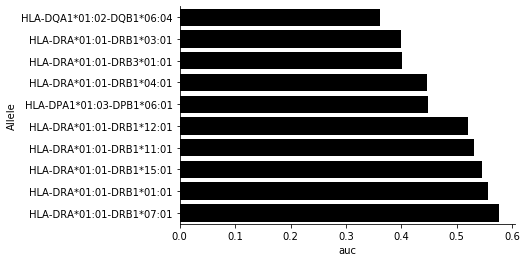

In [45]:
scores_df = []
to_score = validation_df.copy()
for allele, sub_validation_df in validation_df.groupby("hla"):
    to_score["hit"] = 0
    to_score.loc[sub_validation_df.index, "hit"] = 1
    scores_df.append((
        allele,
        sklearn.metrics.roc_auc_score(to_score.hit, -1 * to_score.prediction),
    ))

scores_df = pandas.DataFrame(scores_df, columns=["allele", "auc"])
scores_df = scores_df.sort_values("auc")

seaborn.barplot(data=scores_df, y="allele", x="auc", color='black')
#pyplot.xlim(xmin=0.5)
pyplot.ylabel("Allele")
seaborn.despine()
scores_df

In [55]:
validation_df.original_pmid.value_counts()

31495665    45493
Name: original_pmid, dtype: int64